<a href="https://colab.research.google.com/github/dine1717/EVA6/blob/session6/BN_GN_LN_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/eva/')
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
# this performs the import from the model.py file
import model

from model import BatchNet
from model import LayerNet
from model import GroupNet


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [5]:
train_transforms = transforms.Compose([
                                   transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                   ])

test_transforms = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                                   ])

# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

##### Train and Test functions

In [8]:
def train(model, device, train_loader, optimizer, epoch, l1_reg=False):
    model.train()
    pbar = tqdm(train_loader)
    
    train_losses = []
    train_acc = []
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      if l1_reg:
        L1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
          if 'weight' in name:
            L1_reg = L1_reg + torch.norm(param, 1)
        
        loss = F.nll_loss(y_pred, target) + 10e-4 * L1_reg  
      else :  
        loss = F.nll_loss(y_pred, target)
      
      train_losses.append(loss.cpu().item())
      

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)

    return train_acc, train_losses



def test(model, device, test_loader):
    model.eval()

    test_losses = []
    test_acc = []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').cpu().item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_acc, test_losses

In [9]:
def train_test_display(model, epochs, l1_reg=False):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # model =  model.Net(bn_type).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

  # LR Scheduler
  lambda1 = lambda epoch: 0.85 ** epoch
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  for epoch in range(0, epochs):
      print("EPOCH:", epoch+1)
      acc, loss = train(model, device, train_loader, optimizer, epoch, l1_reg)
      # Since accuracy and loss are returned as a list, we expand it using +
      train_acc += acc
      train_losses += loss
      scheduler.step()
      acc, loss = test(model, device, test_loader)
      test_acc += acc
      test_losses += loss

  return test_acc, test_losses, train_acc, train_losses

In [10]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


#### Batch Net implementation

In [11]:
batch_model = BatchNet().to(device)
summary(batch_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

In [12]:
EPOCHS=20

In [13]:
test_acc_bn, test_losses_bn, train_acc_bn, train_losses_bn = train_test_display(batch_model, EPOCHS, l1_reg=True)

EPOCH: 1


Loss=0.5763522982597351 Batch_id=468 Accuracy=92.23: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.1860, Accuracy: 9451/10000 (94.51%)

EPOCH: 2


Loss=0.4626077711582184 Batch_id=468 Accuracy=95.80: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.2726, Accuracy: 9157/10000 (91.57%)

EPOCH: 3


Loss=0.4896794557571411 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]



Test set: Average loss: 0.2360, Accuracy: 9265/10000 (92.65%)

EPOCH: 4


Loss=0.35245200991630554 Batch_id=468 Accuracy=96.39: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.1331, Accuracy: 9607/10000 (96.07%)

EPOCH: 5


Loss=0.34518688917160034 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]



Test set: Average loss: 0.1296, Accuracy: 9602/10000 (96.02%)

EPOCH: 6


Loss=0.3319501578807831 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]



Test set: Average loss: 0.0994, Accuracy: 9716/10000 (97.16%)

EPOCH: 7


Loss=0.274269700050354 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.1077, Accuracy: 9678/10000 (96.78%)

EPOCH: 8


Loss=0.31082355976104736 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.1307, Accuracy: 9588/10000 (95.88%)

EPOCH: 9


Loss=0.2659895718097687 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]



Test set: Average loss: 0.1196, Accuracy: 9615/10000 (96.15%)

EPOCH: 10


Loss=0.3110508322715759 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0645, Accuracy: 9798/10000 (97.98%)

EPOCH: 11


Loss=0.2866118550300598 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.1277, Accuracy: 9621/10000 (96.21%)

EPOCH: 12


Loss=0.23745043575763702 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]



Test set: Average loss: 0.1006, Accuracy: 9698/10000 (96.98%)

EPOCH: 13


Loss=0.22383266687393188 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]



Test set: Average loss: 0.0686, Accuracy: 9792/10000 (97.92%)

EPOCH: 14


Loss=0.2392669916152954 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0522, Accuracy: 9842/10000 (98.42%)

EPOCH: 15


Loss=0.23231998085975647 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]



Test set: Average loss: 0.0654, Accuracy: 9795/10000 (97.95%)

EPOCH: 16


Loss=0.2050950676202774 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0540, Accuracy: 9836/10000 (98.36%)

EPOCH: 17


Loss=0.28929007053375244 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.0565, Accuracy: 9820/10000 (98.20%)

EPOCH: 18


Loss=0.22688782215118408 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

EPOCH: 19


Loss=0.1702800989151001 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0485, Accuracy: 9837/10000 (98.37%)

EPOCH: 20


Loss=0.275530606508255 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0607, Accuracy: 9830/10000 (98.30%)



In [14]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
      
  return 

Total wrong predictions are 170


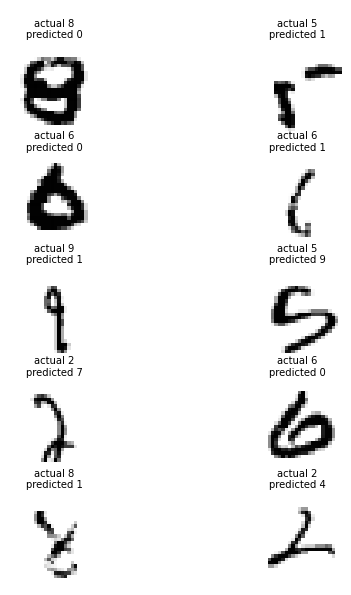

In [15]:
wrong_predictions(test_loader, batch_model,device=device)

##### Layer model

In [16]:
layer_model = LayerNet().to(device)
summary(layer_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

In [17]:
test_acc_ln, test_losses_ln, train_acc_ln, train_losses_ln = train_test_display(layer_model, EPOCHS,l1_reg=False)

EPOCH: 1


Loss=0.09648830443620682 Batch_id=468 Accuracy=87.92: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0807, Accuracy: 9751/10000 (97.51%)

EPOCH: 2


Loss=0.0695766881108284 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]



Test set: Average loss: 0.0447, Accuracy: 9864/10000 (98.64%)

EPOCH: 3


Loss=0.059906940907239914 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0393, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.07609798014163971 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.0343, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.058740075677633286 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0319, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.04144792631268501 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]



Test set: Average loss: 0.0262, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.0040242900140583515 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]



Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.02120102010667324 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.03364524617791176 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0231, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.00876076240092516 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.024555357173085213 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.006139138713479042 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]



Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.01779497228562832 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.009688915684819221 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.002090507885441184 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]



Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.027268752455711365 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]



Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.03313327953219414 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]



Test set: Average loss: 0.0197, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.03359774872660637 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0184, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.003399916924536228 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.004089830443263054 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]



Test set: Average loss: 0.0189, Accuracy: 9935/10000 (99.35%)



Total wrong predictions are 65


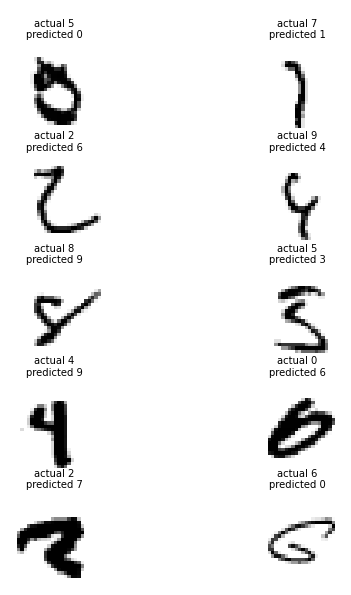

In [18]:
wrong_predictions(test_loader, layer_model,device=device)

##### Group normalization

In [19]:
group_model = GroupNet().to(device)
summary(group_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

In [20]:
test_acc_gn, test_losses_gn,train_acc_gn,train_losses_gn = train_test_display(group_model, EPOCHS)

EPOCH: 1


Loss=0.041394080966711044 Batch_id=468 Accuracy=90.74: 100%|██████████| 469/469 [00:16<00:00, 27.59it/s]



Test set: Average loss: 0.0698, Accuracy: 9786/10000 (97.86%)

EPOCH: 2


Loss=0.08466216921806335 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0501, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.028809530660510063 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]



Test set: Average loss: 0.0356, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.02664385922253132 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]



Test set: Average loss: 0.0304, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.010552491061389446 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]



Test set: Average loss: 0.0300, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.06272103637456894 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]



Test set: Average loss: 0.0281, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.0032301016617566347 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0259, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.04476647078990936 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]



Test set: Average loss: 0.0218, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.007181481923907995 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]



Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.00410086615011096 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.01309238001704216 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]



Test set: Average loss: 0.0209, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.047156453132629395 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]



Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.014647702686488628 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.009494456462562084 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.034540724009275436 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.0030224330257624388 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]



Test set: Average loss: 0.0184, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.004003128502517939 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:18<00:00, 24.68it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.011332434602081776 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]



Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.026723213493824005 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.004948367830365896 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]



Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)



Total wrong predictions are 64


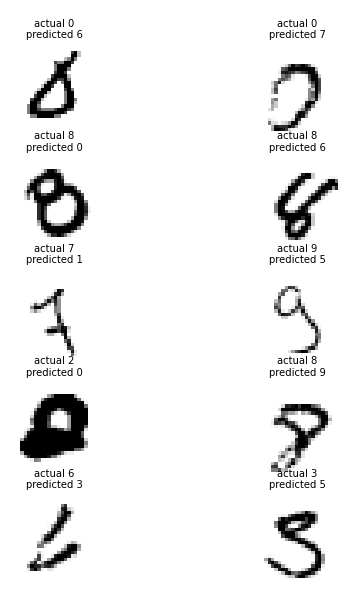

In [21]:
wrong_predictions(test_loader, group_model,device=device)

In [22]:
type(train_losses_bn)

list

Text(0.5, 1.0, 'Test Accuracy')

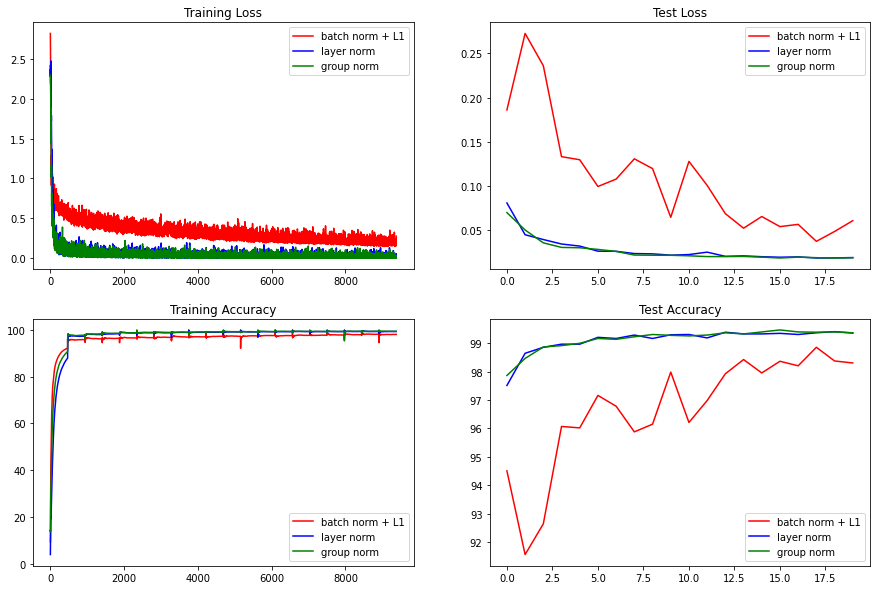

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_bn,'-r',label='batch norm + L1')
axs[0, 0].plot(train_losses_ln,'-b',label='layer norm')
axs[0, 0].plot(train_losses_gn,'-g',label='group norm')
axs[0, 0].legend(loc="upper right")
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_bn,'r',label='batch norm + L1')
axs[1, 0].plot(train_acc_ln,'b',label='layer norm')
axs[1, 0].plot(train_acc_gn,'g',label='group norm')
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Training Accuracy")

epochs =[x for x in range(15)]
axs[0, 1].plot(test_losses_bn,'r',label='batch norm + L1')
axs[0, 1].plot(test_losses_ln,'b',label='layer norm')
axs[0, 1].plot(test_losses_gn,'g',label='group norm')
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_bn,'r',label='batch norm + L1')
axs[1, 1].plot(test_acc_ln,'b',label='layer norm')
axs[1, 1].plot(test_acc_gn,'g',label='group norm')
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Accuracy")